# Benchmarking the cost of concept explanation retrieval

Loading dataset for board size 7


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


Average time for JEM:  0.22116482973098756


100%|██████████| 100/100 [00:01<00:00, 58.23it/s]


Average time for CBM:  0.01707709550857544


100%|██████████| 100/100 [00:00<00:00, 178.52it/s]


Average time for concept functions:  0.005563018321990967


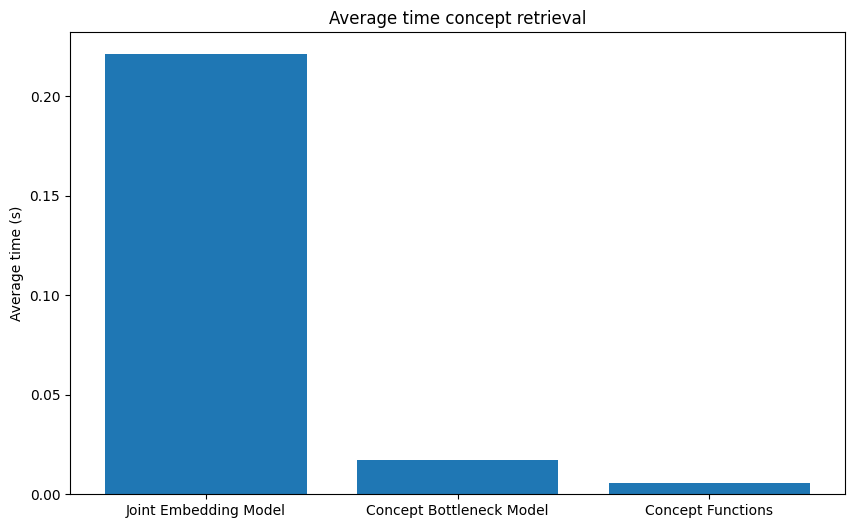

In [1]:
# Benchmarking joint embedding model, concept botleneck model and concept functions

import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}

sys.path.append(os.path.abspath(os.path.join(os.path.pardir, 'src')))

import tensorflow as tf

# Set memory growth
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from jem import data_utils, JointEmbeddingModel
from policy import ConceptNet
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

board_size = 7

# Load the pickle file
states, _, _, max_sent_len, vocab = data_utils.load_datasets_from_pickle(board_size)
explanation_list = data_utils.get_explanation_list()

# Shuffle the states
indices = np.arange(len(states))
np.random.shuffle(indices)
states = states[indices]


# Remove the index 2 from the explanation_list (two_eyes is not in the dataset)
explanation_list = [explanation_list[i] for i in range(len(explanation_list)) if i != 2]

# Load the joint embedding model
jem = JointEmbeddingModel(load_path='../models/jem/joint_embedding_model.keras')
cbm = ConceptNet(board_size, 7, None, False)

# Benchmarking in average time how long it takes to predict an explanation
n = 100 if len(states) > 100 else len(states)

def concept_functions():
    concept_list = data_utils.concept_functions_to_use()
    # Remove the index 2 from the concept functions (two_eyes is not in the dataset)
    concept_list = [concept_list[i] for i in range(len(concept_list)) if i != 2]
    return concept_list


jem_times = []
for i in tqdm(range(n)):
    start = time.time()
    jem.predict_concept(states[i], 
                        explanation_list, 
                        vocab, 
                        max_sent_len, 
                        data_utils.convert_explanation_to_integers, 
                        concept_functions)
    end = time.time()
    jem_times.append(end - start)

print('Average time for JEM: ', np.mean(jem_times))

cbm_times = []
for i in tqdm(range(n)):
    start = time.time()
    cbm.predict_concepts(states[i])
    end = time.time()
    cbm_times.append(end - start)

print('Average time for CBM: ', np.mean(cbm_times))

concept_functions_times = []
for i in tqdm(range(n)):
    start = time.time()
    data_utils.get_explanation_from_state(states[i])
    end = time.time()
    concept_functions_times.append(end - start)

print('Average time for concept functions: ', np.mean(concept_functions_times))

# Plot the average time for each method
methods = ['Joint Embedding Model', 'Concept Bottleneck Model', 'Concept Functions']
times = [np.mean(jem_times), np.mean(cbm_times), np.mean(concept_functions_times)]
plt.figure(figsize=(10, 6))
plt.bar(methods, times)
plt.ylabel('Average time (s)')
plt.title('Average time concept retrieval')
plt.show()